# Generative Adverserial Network

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import layers

In [98]:
# read the dataset
(X_train, y_train), (X_test,y_test) = tf.keras.datasets.mnist.load_data()

In [99]:
def display_image(training_images, training_labels, number_of_images_disply, name_of_dataset):
    
    if not training_images.shape[0] == 0:
        # display images from the dataset
        index= []
        while  len(index) < number_of_images_disply:
            i = np.random.randint(0,training_labels.shape[0])
            index.append(i)

        print(training_images[0].shape)
        
        

        num_rows = 1  # Number of rows
        num_cols = len(index)  # Number of columns

            # Create a figure with a grid layout
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4))

            # If there is only one image, `axes` is not a list, so we need to convert it to a list
        if num_cols == 1:
            axes = [axes]

            # Iterate through the images and display them
        for i, ax in enumerate(axes):
            ax.imshow(training_images[index[i]])
           
            ax.axis('off')
            

        plt.title(f"Images from datasets {name_of_dataset}")
        plt.show()

    else:
        ValueError("training_x_images doesn't contain images, it is empty")

(28, 28)


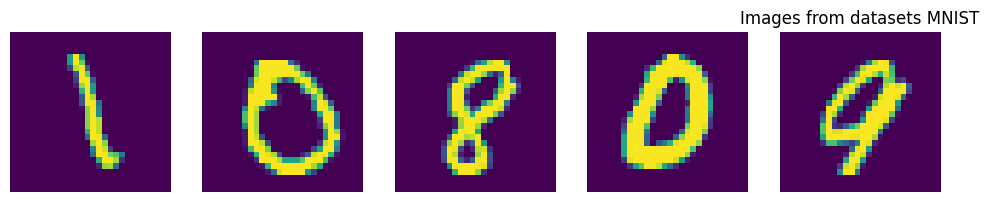

In [100]:
display_image(X_train,y_train,5,"MNIST")

In [101]:
X_train = X_train.reshape(X_train.shape[0],28,28,1).astype('float32')

In [102]:
X_train.shape

(60000, 28, 28, 1)

In [103]:
X_train[0].min(),X_train[0].max()

(0.0, 255.0)

As we have noticed now the min max values has different ranges so it is better to have them on the same range. Which makes processing faster and efficient.

In [104]:
# Normalization of image data
#X_train = X_train / 255.0
X_train = (X_train - 127.5) / 127.5

In [106]:
buffer_size = 60000
batch_size = 256

In [108]:
# Convert the array to tensor
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [111]:
!git push

To https://github.com/GVanave/Image-Generation-with-GAN
   b9c8bad..076a216  main -> main


# Design the Generator

In [171]:


def Generator():
    generator_net = tf.keras.Sequential()

    generator_net.add(layers.Dense(7*7*256, input_shape=(100,)) ) # Fully connected layer
    generator_net.add(layers.BatchNormalization())
    generator_net.add(layers.LeakyReLU())

    # Reshape the input because we want to use the convolutional layers
    generator_net.add(layers.Reshape((7, 7, 256)))
    generator_net.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    generator_net.add(layers.BatchNormalization())
    generator_net.add(layers.LeakyReLU())

    generator_net.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    generator_net.add(layers.BatchNormalization())
    generator_net.add(layers.LeakyReLU())

    generator_net.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', activation='sigmoid'))
    generator_net.add(layers.BatchNormalization())

    generator_net.summary()

    return generator_net



In [172]:
generator = Generator()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 12544)             1266944   
                                                                 
 batch_normalization_24 (Bat  (None, 12544)            50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_18 (Conv2D  (None, 14, 14, 128)      819328    
 Transpose)                                                      
                                                                 
 batch_normalization_25 (Bat  (None, 14, 14, 128)    

In [173]:
# create a noise vector with shape 
noise  = tf.random.normal([1,100])

In [174]:
generated_image = generator.predict(noise)


1/1 [==============================] - 0s 165ms/step


Text(0.5, 1.0, 'Generated image')

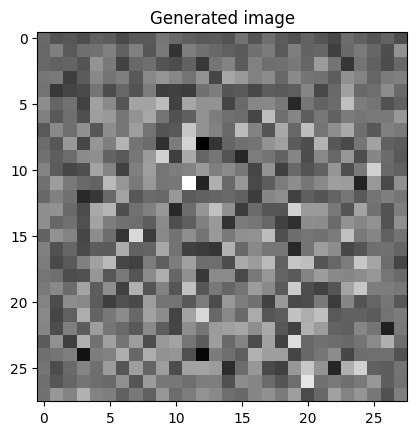

In [175]:
plt.imshow(generated_image[0,:,:,0], cmap = 'gray')
plt.title("Generated image")

In [176]:
generated_image.shape

(1, 28, 28, 1)

# Design of the Discriminator

In [149]:
def Discriminator():
    dis_network = tf.keras.Sequential()

    # discriminator takes the image as input
    # 14 * 14 * 64
    dis_network.add(layers.Conv2D(64, (5,5), strides = (2,2), padding = 'same', input_shape = (28,28,1)))
    dis_network.add(layers.LeakyReLU())
    dis_network.add(layers.Dropout(0.2))

    # 7 * 7 * 128
    dis_network.add(layers.Conv2D(128, (5,5), strides = (2,2), padding = 'same', input_shape = (28,28,1)))
    dis_network.add(layers.LeakyReLU())
    dis_network.add(layers.Dropout(0.2))

    dis_network.add(layers.Flatten())
    dis_network.add(layers.Dense(1))

    dis_network.summary()

    return dis_network

In [150]:
disciminator  = Discriminator()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [177]:
# check the discriminator
disciminator.predict(generated_image)

1/1 [==============================] - 0s 101ms/step


array([[0.04896173]], dtype=float32)

# building of loss function


*Calculate the loss for generator and discriminator*

In [193]:
# define a loss function
cross_ent = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [194]:
def generator_loss(fake_output):
    return cross_ent(tf.ones_like(fake_output), fake_output)


In [195]:
def discriminator_loss(expected_output, fake_output):

    real_loss = cross_ent(tf.ones_like(expected_output), expected_output)
    fake_loss = cross_ent(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss

    return total_loss

In [196]:
# define the optimizer for the generator
opt_generator = tf.keras.optimizers.Adam(learning_rate = 0.00001)
opt_discriminator = tf.keras.optimizers.Adam(learning_rate = 0.00001)

# Define the parameters


In [197]:
epochs = 100
noise_dim  = 100
num_images_to_generator = 16


# Define the training step

In [201]:
def train_step(images):
    noise_generated = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise_generated)

        # discriminator takes this geenrated images and tried to make guesses
        fake_output = disciminator(generated_images)
        # discriminator also takes original images
        expected_output = disciminator(images)

        # calculate the generator and discriminator loss
        calculated_gen_loss = generator_loss(fake_output)
        calculated_dis_loss = discriminator_loss(expected_output, fake_output)


    # define the parameters needs to be optimized during the training, one param will be generator parameters and another is generator loss
    trainiable_parameters_generator_network = generator.trainable_variables
    gradient_generator = gen_tape.gradient(calculated_gen_loss, trainiable_parameters_generator_network)


    # define the parameters needs to be optimized during the training, one param will be discriminator parameters and another is discriminator loss
    trainiable_parameters_discriminator_network = disciminator.trainable_variables
    gradient_discriminator = disc_tape.gradient(calculated_dis_loss, trainiable_parameters_discriminator_network)

    # call the designed optimizers 

    opt_generator.apply_gradients(zip(gradient_generator, generator.trainable_variables))
    opt_discriminator.apply_gradients(zip(gradient_discriminator, disciminator.trainable_variables))


# Training of GAN

In [204]:
number_of_images_to_generate = 16

In [215]:
test_image = tf.random.normal([number_of_images_to_generate, noise_dim])

In [216]:
def train_GAN(dataset, epochs, test_images):
    for epoch in range(epochs):
        for image_batch in dataset:
            #print(image_batch.shape)
            train_step(image_batch)
        print("Training Epoch:", epoch + 1)
        generated_image = generator(test_images)
        fig  = plt.figure(figsize = (10,10))
        for i in range(generated_image.shape[0]):
            plt.subplot(4,4, i+1)
            plt.imshow(generated_image[i,:,:,0] * 127.5 + 127.5 )
            plt.axis("off")
        plt.show



In [217]:
train_GAN(X_train, epochs=20, test_images = test_image)

Training Epoch: 1
Training Epoch: 2
